# Solution (Python)

### Functions to Read in Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

""" Returns a dataframe from a comma-separated file containing NGram counts."""
def read_counts(file_name):
    names = ['Year', 'Num_Per_Million', 'Num_Tokens', 'Num_Words']
    dtype = {'Year': np.int32, 'Num_Per_Million': np.float64, 'Num_Tokens': np.int32, 'Num_Words': np.int32}
    counts_df = pd.read_csv(file_name, sep=',', header=0, names=names, dtype=dtype)
    return counts_df

""" Returns a dataframe from a tab-separated file containing NGram contexts. """
def read_context(file_name):
    names = ['Year', 'Type', 'Source', 'Context']
    dtype = {'Year': np.int32, 'Type': str, 'Source': str, 'Context': str}
    context_df = pd.read_csv(file_name, sep='\t', header=0, names=names, dtype=dtype)
    return context_df

""" Returns a dataframe from a comma-separated file containing NGram counts separated by text category."""
def read_decades_counts(file_name):
    names = ['FIC', 'MAG', 'NEWS', 'NF', 'Total', 'Percent_Fiction']
    dtype = {'FIC' : np.int32, 'MAG' : np.int32, 'NEWS' : np.int32, 'NF' : np.int32, 'Total' : np.int32, 'Percent_Fiction' : np.float64}
    counts_df = pd.read_csv(file_name, sep=',', header=0, index_col=0, names=names, dtype=dtype)
    return counts_df

## <strong> 1.	The Michel et al study used frequency plots of year ngrams (such as '1883') to show that the use of years' ngrams have decreased faster over time. They use these plots to conclude that we "forget faster" as a society. However, critics state that the Google ngrams data contains an overabundance of academic literature, which might render these conclulsions invalid.

Use the included data from the COHA database to create frequency plots for the years '1883', '1910', and '1950'. Do these plots show similar trends to those shown in Figure 3a? </strong>

Like the Google NGrams data, the plots of ngram frequencies over time could also be seen as exponential curves.

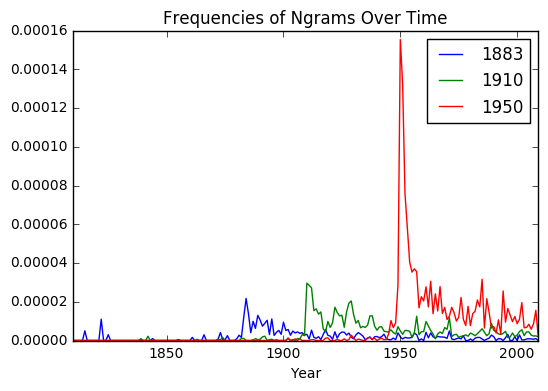

In [2]:
ngrams = [1883, 1910, 1950]
plt.hold(True)
for ngram in ngrams:
    file_name = 'coha_{}_counts.csv'.format(ngram)
    df = read_counts(file_name)
    plt.plot(df.Year, df.Num_Per_Million * 1.0 / 1000000)
    plt.xlim([1810,2009])
    plt.xlabel("Year")
    plt.legend(ngrams)
plt.title('Frequencies of Ngrams Over Time')
plt.show()
plt.close()

For comparison, the Google NGrams frequency plots:

In [3]:
from IPython.core.display import display, HTML
display(HTML('<center><h1>Ngram Frequencies</h1></center>'))
embed_text = '<iframe name="ngram_chart" src="https://books.google.com/ngrams/interactive_chart?content=1883%2C+1910%2C+1950&year_start=1800&year_end=2000&corpus=15&smoothing=3&share=&direct_url=t1%3B%2C1883%3B%2Cc0%3B.t1%3B%2C1910%3B%2Cc0%3B.t1%3B%2C1950%3B%2Cc0" width=900 height=400 marginwidth=0 marginheight=0 hspace=0 vspace=0 frameborder=0 scrolling=no></iframe>'
display(HTML(embed_text))

To test whether the "forgetting faster" effect exists in the COHA corpus, we compute the halflife two ways. In Michel et al 2011, the halflives for 1883, 1910, and 1950 are roughly 32, 16, and 15, respectively (Figure 3A). We don't find the same pattern of decreasing halflives with the COHA corpus.

First, we computed the halflives of each ngram by finding the first year after the ngram year in which the frequency is at most half the frequency of the ngram during the ngram year. For example if the ngram is '1883' and its frequency in 1883 was 0.002, then we find the first year after 1883 in which the frequency of '1883' is at most 0.001. We consider the halflife of 1883 to be the difference between these two years.

In [4]:
""" Finds the first index of a data frame for which the 'Num_Per_Million' column is
less than or equal to a given value. Returns -1 if all values in the
'frequencies' column are greater than the given value. """
def find_closest_val_index(df, start_index, value):
    for i in range(start_index, len(df.index) - 1):
        if df.iloc[i]['Num_Per_Million'] <= value:
            return i
    return -1

""" Computes half-life for year X by finding the first year after X for which
the frequency of the n-gram for X is less than half of the frequency in year X."""
def compute_halflife(df, year):
    start_index = df[counts_df.Year == ngram].index.values[0]
    start = df.iloc[start_index]['Num_Per_Million']
    half_index = find_closest_val_index(df, start_index, start / 2.0)
    half_year = df.iloc[half_index]['Year']
    return int(half_year) - int(year)

In [5]:
for ngram in ngrams:
    count_file_name = 'coha_{}_counts.csv'.format(ngram)
    counts_df = read_counts(count_file_name)

    halflife = compute_halflife(counts_df, ngram)
    
    print "Year: %s \t Halflife: %s" % (ngram, halflife)

Year: 1883 	 Halflife: 3
Year: 1910 	 Halflife: 5
Year: 1950 	 Halflife: 2


We also compute halflife by finding an exponential fit of the data.

In [6]:
from scipy.optimize.minpack import curve_fit
def compute_exp_fit(counts_df, ngram):
    start_index = counts_df[counts_df.Year == int(ngram)].index.values[0]
    start_freq = counts_df.iloc[start_index]['Num_Per_Million']
    
    x = counts_df.iloc[start_index:]['Year'].values
    x_sub = np.subtract(x, ngram)
    y = counts_df.iloc[start_index:]['Num_Per_Million'].values * 1.0 / 1000000
    guess_a, guess_b, guess_c = start_freq, -0.2, 0
    guess = [guess_a, guess_b, guess_c]

    exp_decay = lambda x, A, t, y0: A * np.exp(x * t) + y0

    params, cov = curve_fit(exp_decay, x_sub, y, p0=guess)
    return(params)

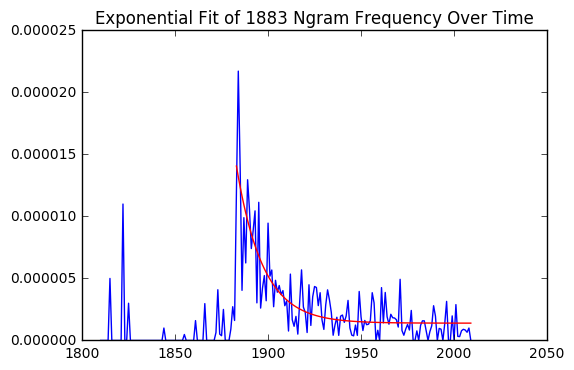

Year: 1883 	 Halflife = 9.80302159089


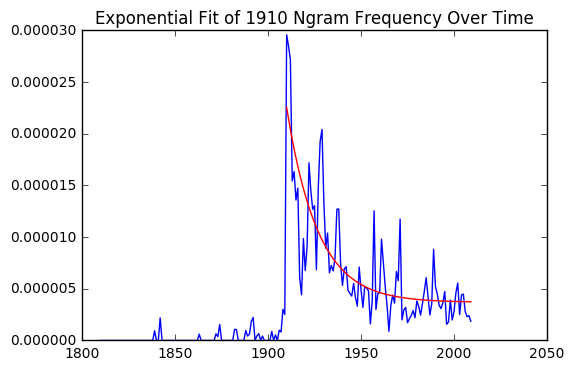

Year: 1910 	 Halflife = 11.5899127681


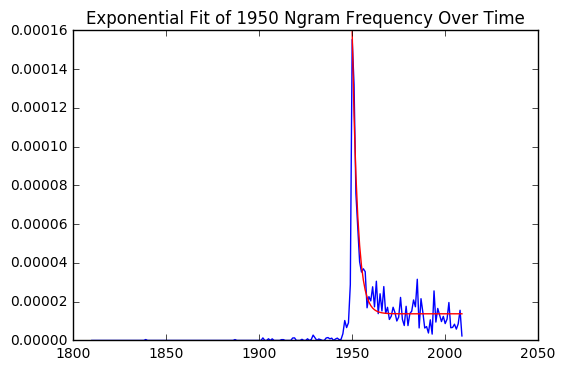

Year: 1950 	 Halflife = 1.95874803674


In [7]:
for ngram in ngrams:
    count_file_name = 'coha_{}_counts.csv'.format(ngram)
    counts_df = read_counts(count_file_name)

    start_index = counts_df[counts_df.Year == int(ngram)].index.values[0]
    start_freq = counts_df.iloc[start_index]['Num_Per_Million']
    
    x = counts_df.iloc[start_index:]['Year'].values
    x_sub = np.subtract(x, ngram)
    
    params = compute_exp_fit(counts_df, ngram)
    A, t, y0 = params
    plt.plot(counts_df.Year, counts_df.Num_Per_Million * 1.0 / 1000000)
    plt.plot(x, A * np.exp((x - ngram) * t) + y0, color = 'r')
    plt.title('Exponential Fit of %s Ngram Frequency Over Time' % ngram)
    plt.show()
    halflife = np.log(2) * 1.0 / (-t)
    print "Year: %s \t Halflife = %s" % (ngram, halflife)

## <strong>2. One of the criticisms of the Google NGrams corpus is that it over-represents academic literature. The COHA Corpus categorizes texts according to four categories (Fiction, Magazines, Newspapers, and Nonfiction) and provides the percent representation of each category for each year. Can you categories from the COHA database show if the "forgetting faster" effect is caused by an over-representation of academic literature?</strong>

In question 1, we saw that the overall COHA corpus similarly shows exponential decay, but did not show decreasing half-lives for the ngrams 1883, 1910, and 1950. We can look separately at ngrams from the four COHA categories, but we don't find a forgetting faster effect in any of these categories, either.

However, it's possible that the categories are not specific enough (academic articles might fit under nonfiction, but looking only at the 'NF' category includes other non-fiction texts as well). From a [description of the COHA corpus](http://davies-linguistics.byu.edu/ling450/davies_corpora_2011.pdf), the corpus categories includes texts from the following sources:
* Fiction: Project Gutenberg, Making of America, scanned books, movie and play scripts, and COCA
* Magazines: Making of America, scanned and PDF magazines, and COCA
* Newspapers: At least five different newspapers, COCA, and others
* Nonfiction: Project Gutenberg, www.archive.org, scanned books, and COCA

Also, since category counts are only available by decade, it's possible that aggregating the counts over each decade hides a trend.

In [8]:
def aggregate_context(context_df):
    index = [1810, 1820, 1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000]
    columns = ['FIC', 'MAG', 'NEWS', 'NF']
    agg_df = pd.DataFrame(0, index=index, columns=columns, dtype=np.int32)
    for index, row in context_df.iterrows():
        decade = row.Year / 10 * 10
        row_type = row.Type
        agg_df.ix[decade, row_type] += 1
    return agg_df

def get_aggregate_freqs(agg_counts_df, agg_context_df):
    freqs_df = agg_context_df.copy()
    indices = [1810, 1820, 1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000]
    columns = ['FIC', 'MAG', 'NEWS', 'NF']
    for index in indices:
        for col in columns:
            freqs_df.ix[index, col] = freqs_df.ix[index, col] * 1.0 / agg_counts_df.ix[index, col]
            if agg_counts_df.ix[index, col] == 0:
                freqs_df.ix[index, col] = 0
    return freqs_df

def compute_exponential_fit(df, year, genre):
    start_index = df.index.get_loc(year, method='nearest')
    freqs = df.iloc[start_index :][genre].values
    years = df.iloc[start_index :].index.astype(int).values
    freqs[freqs == 0] = 1e-10
    log_freqs = np.log(freqs.astype(float))
    # freq = A*e^{B * year} -> log(freq) = logA + year * B
    # fit[0] = B, fit[1] = logA -> A = e^{fit[1]}
    fit = np.polyfit(years, log_freqs, 1)
    return fit

Year: 1883 	 Halflife: 17.3517188925
Year: 1910 	 Halflife: 47.1032159614
Year: 1950 	 Halflife: -112.114236398


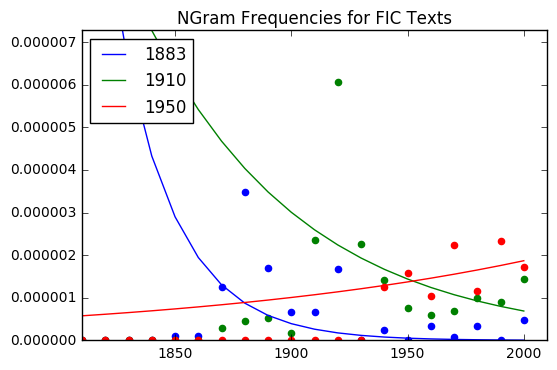

Year: 1883 	 Halflife: 32.6999655885
Year: 1910 	 Halflife: 36.6700105223
Year: 1950 	 Halflife: 18.6925908564


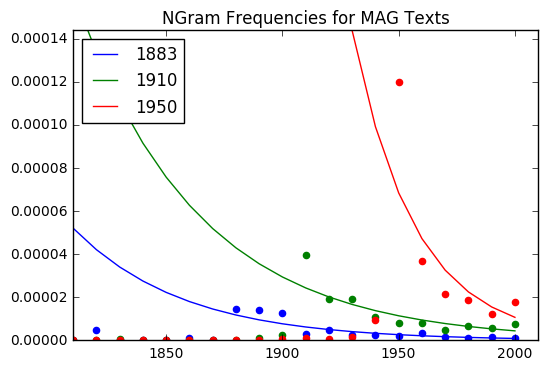

Year: 1883 	 Halflife: 22.3637638513
Year: 1910 	 Halflife: 26.615788358
Year: 1950 	 Halflife: 14.3475969017


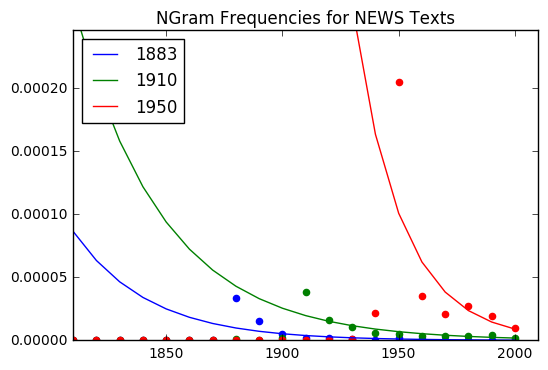

Year: 1883 	 Halflife: 122.7590216
Year: 1910 	 Halflife: 52.2557075787
Year: 1950 	 Halflife: 87.9118388969


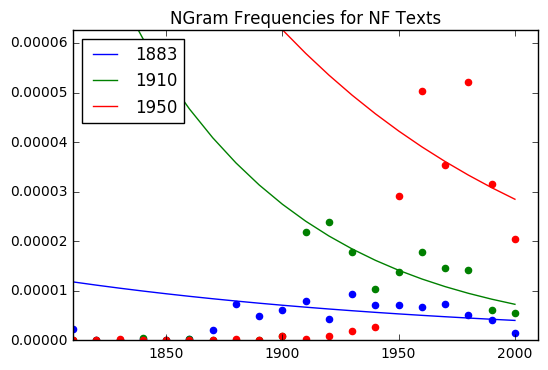

In [9]:
decades_file_name = 'coha_decade_counts.csv'
decades_counts_df = read_decades_counts(decades_file_name)
colors = {1883:'b', 1910:'g', 1950:'r'}
categories = ['FIC', 'MAG', 'NEWS', 'NF']
fig_nums = {'FIC': 0, 'MAG': 1, 'NEWS': 2, 'NF': 3}
MAX_VALUE_SCALE = 1.2

for category in categories:
    max_value = 0
    for ngram in ngrams:
        context_file_name = 'coha_{}_clean.txt'.format(ngram)
        context_df = read_context(context_file_name)
        agg_context_df = aggregate_context(context_df)
        agg_df = get_aggregate_freqs(decades_counts_df, agg_context_df)
        decade = int(ngram) / 10 * 10

        ngram_max_value = agg_df[category].max()
        max_value = max(max_value, ngram_max_value)
        fit = compute_exponential_fit(agg_df, ngram, category)
        halflife = np.log(2) * 1.0 / (-fit[0])
        print "Year: %s \t Halflife: %s" % (ngram, halflife)

        plt.figure(fig_nums[category])
        plt.scatter(agg_df.index, agg_df[category], color=colors[ngram])
        plt.plot(agg_df.index, np.exp(fit[1]) * np.exp(agg_df.index * fit[0]), color=colors[ngram])
    plt.legend(ngrams, loc='upper left')
    plt.xlim([1810, 2010])
    plt.ylim([0, max_value * MAX_VALUE_SCALE])
    plt.title('NGram Frequencies for {} Texts'.format(category))
    plt.show()

Although these categories don't allow us to directly check if the "forgetting faster" effect comes from an overrepresentation of academic literature, the 'newspaper' and 'magazine' categories could indicate whether society is forgetting faster (since newspapers and magazines might correspond more closely to what people talk about). The frequencies of the three selected ngrams do not show decreasing halflives.

## <strong>3. The COHA corpus also contains information about each ngram's context. Another criticism of Google NGrams is that it does not give any information about the context of ngrams in the corpus. What (if any) additional understanding can you gain from the contexts provided in the COHA corpus data?</strong>

Although there are too many ngrams to look at each one's context individually, we can sample the contexts to see whether year ngrams are actually being used to describe years. Since the COHA corpus also separates by category, we can see how this representation differs across categories.

In [10]:
for category in categories:
    print("*******Contexts for category %s*******" % category)
    for ngram in ngrams:
        print("*****Contexts for ngram %s*****" % ngram)
        context_file_name = 'coha_{}_clean.txt'.format(ngram)
        context_df = read_context(context_file_name)
        context_df_nf = context_df[context_df.Type == category]

        pd.options.display.max_colwidth = 300
        for i in range(10):
            print(context_df_nf.Context.sample(1).to_string(index=False))
            print("\n")
        print("\n\n")

*******Contexts for category FIC*******
*****Contexts for ngram 1883*****
April 22, 1883, and St. Gallen during the week of December 2, 1883. A motion picture version of The Galley Slave, in which Theda Bara was


It lasted sixty-three years. Old Levi Plummer lasted sixty-three years. He died in 1883. And there were two of him. There usually are. There's a


worthy of the poem whence it had risen. The fruit of the winter of 1883 and 1884, included also the too-popular " Nathalie " dances, (where,


It lasted sixty-three years. Old Levi Plummer lasted sixty-three years. He died in 1883. And there were two of him. There usually are. There's a


April 22, 1883, and St. Gallen during the week of December 2, 1883. A motion picture version of The Galley Slave, in which Theda Bara was


BY F. MARION CRAWFORD Author OF " MR. ISAACS " London MACMILLAN AND CO. 1883 Dedicated TO MY DEAR FRIENDS THE COUNTESS MARGARET AND CLAUDIUS, PH.D. DOCTOR CLAUDIUS


-- M. le Marquis G. de Saporta, in Popular 

Although a instances use the ngram in contexts such as citations, it seems like most of the contexts use the ngram to refer to the year itself. This supports the 'culturomic' idea that ngram frequencies show how often writers refer to a year.

Ngrams from the "Fiction" category seem to show a higher proportion of contexts that use the ngram in a citation, rather than in reference to the specific year. This might explain the difference between the frequency plots for "FIC" and the frequency plots for the other three categories in Part 2.

Each context is relatively short, which makes it difficult to gain a lot of information about how these ngrams are used in their respective texts. However, using the contexts we can look at the words that are most frequently used with each ngram.

In [11]:
from nltk import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import LancasterStemmer
import string

stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
stemmer = LancasterStemmer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    #normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    normalized = " ".join(stemmer.stem(word) for word in punc_free.split())
    return normalized

In [12]:
def print_top(context_df, num_top_words=10):
    doc_complete = context_df['Context'].str.cat(sep=' ')
    doc_complete_unicode = unicode(doc_complete, errors='ignore')
    doc_clean = clean(doc_complete_unicode)
    doc_words = word_tokenize(doc_clean)
    fdist = FreqDist(doc_words)
    top_words = fdist.most_common(num_top_words)
    print(ngram)
    for i in range(num_top_words - 1):
        print str(top_words[i][0]), ":", top_words[i][1], ",",
    print str(top_words[num_top_words - 1][0]), ":", top_words[num_top_words - 1][1]
    print "\n"

In [13]:
ngrams = ['1883', '1910', '1950', 'influenza', 'feminism']

for ngram in ngrams:
    context_filename = 'coha_{}_clean.txt'.format(ngram)
    context_df = read_context(context_filename)
    print_top(context_df)

1883
1883 : 884 , year : 114 , new : 80 , stat : 62 , act : 59 , on : 57 , publ : 49 , first : 47 , law : 46 , tim : 46


1910
1910 : 1834 , year : 234 , new : 170 , stat : 159 , cent : 134 , per : 124 , sint : 121 , first : 110 , on : 103 , mad : 88


1950
1950 : 3371 , new : 586 , york : 424 , year : 414 , tim : 333 , sint : 287 , stat : 282 , 1950s : 247 , us : 234 , edit : 230


influenza
influenz : 790 , vir : 101 , epidem : 92 , diseas : 84 , vaccin : 70 , on : 67 , us : 61 , year : 57 , new : 53 , last : 51


feminism
femin : 361 , wom : 115 , on : 35 , new : 33 , men : 33 , right : 32 , mov : 28 , rad : 22 , it : 22 , say : 22




We can also try to look at how words used with the ngrams change over time, but it the size of the corpus might limit this analysis: when we break down the corpuses by year, the most frequently used terms only occur a few times in the given year.

In [14]:
def print_top_yearly(context_df, num_top_words=3):
    years = range(1810, 2010)

    for year in years:
        yearly_df = context_df[context_df.Year == year]
        if (yearly_df.shape[0] > 0):
            doc_yearly = yearly_df['Context'].str.cat(sep=' ')
            doc_yearly_unicode = unicode(doc_yearly, errors='ignore')
            doc_clean = clean(doc_yearly_unicode)
            doc_words = word_tokenize(doc_clean)
            fdist = FreqDist(doc_words)
            top_words = fdist.most_common(num_top_words)
            print year
            for i in range(num_top_words - 1):
                print str(top_words[i][0]), ":", top_words[i][1], ",",
            print str(top_words[num_top_words - 1][0]), ":", top_words[num_top_words - 1][1]

In [15]:
ngram = 1883
print "**********Ngram: %s**********" % ngram
context_filename = 'coha_{}_clean.txt'.format(ngram)
context_df = read_context(context_filename)
print_top_yearly(context_df)

**********Ngram: 1883**********
1815
dodg : 2 , year : 2 , earl : 1
1822
1883 : 7 , overt : 6 , concert : 3
1825
box : 1 , 1 : 1 , posthum : 1
1844
religy : 1 , lif : 1 , 27 : 1
1855
car : 2 , sleep : 2 , 2489 : 1
1861
noth : 2 , 1883 : 2 , essay : 1
1866
1883 : 5 , phenomen : 2 , cold : 2
1872
septimi : 2 , felton : 2 , lif : 1
1873
1883 : 13 , new : 5 , york : 5
1874
third : 1 , would : 1 , fit : 1
1875
med : 1 , christian : 1 , grant : 1
1876
also : 6 , pp : 5 , 1883 : 5
1880
pount : 2 , 1883 : 2 , fair : 1
1881
1883 : 4 , copyright : 2 , new : 2
1882
1883 : 3 , claim : 2 , gen : 2
1883
1883 : 24 , illust : 6 , copyright : 5
1884
1883 : 54 , new : 9 , copyright : 9
1885
1883 : 26 , mr : 4 , may : 4
1886
1883 : 9 , bil : 3 , rep : 3
1887
1883 : 22 , key : 5 , law : 5
1888
1883 : 13 , act : 3 , day : 2
1889
1883 : 30 , year : 7 , rob : 6
1890
1883 : 17 , act : 4 , report : 3
1891
1883 : 16 , old : 3 , party : 3
1892
1883 : 16 , year : 3 , man : 3
1893
1883 : 18 , dear : 8 , unc : 7
18

In [16]:
ngram = 1910
print "**********Ngram: %s**********" % ngram
context_filename = 'coha_{}_clean.txt'.format(ngram)
context_df = read_context(context_filename)
print_top_yearly(context_df)

**********Ngram: 1910**********
1839
1910 : 2 , certain : 1 , period : 1
1842
1830 : 2 , pop : 2 , 1820 : 2
1863
ant : 1 , sheffield : 1 , theref : 1
1872
new : 2 , accord : 1 , stockton : 1
1873
slav : 2 , galley : 2 , play : 1
1874
year : 2 , 1910 : 2 , rag : 1
1882
copyright : 2 , chapt : 2 , new : 2
1883
copyright : 3 , 1910 : 2 , bon : 1
1888
1910 : 2 , railroad : 2 , coupon : 1
1889
tim : 2 , week : 1 , oth : 1
1890
would : 2 , claim : 1 , gift : 1
1891
year : 5 , 1910 : 4 , city : 3
1892
1910 : 4 , henry : 3 , janu : 2
1894
end : 1 , silv : 1 , lead : 1
1895
on : 1 , said : 1 , mil : 1
1897
b : 2 , company : 2 , j : 2
1902
year : 2 , 1910 : 2 , show : 1
1904
impress : 4 , march : 2 , right : 1
1906
may : 2 , 1910 : 2 , shal : 2
1907
march : 3 , april : 3 , 1910 : 2
1908
1910 : 6 , repres : 2 , taft : 2
1909
1910 : 9 , year : 3 , issu : 3
1910
1910 : 70 , publ : 15 , new : 14
1911
1910 : 77 , year : 9 , off : 9
1912
1910 : 66 , per : 14 , cent : 13
1913
1910 : 37 , stat : 9 , mad

In [17]:
ngram = 1950
print "**********Ngram: %s**********" % ngram
context_filename = 'coha_{}_clean.txt'.format(ngram)
context_df = read_context(context_filename)
print_top_yearly(context_df)

**********Ngram: 1950**********
1839
school : 2 , and : 1 , paedagog : 1
1887
zn : 2 , 975 : 2 , x : 2
1902
1950 : 3 , year : 2 , may : 2
1905
stat : 2 , 1950 : 2 , already : 1
1907
1950 : 2 , conveny : 1 , century : 1
1912
king : 1 , monst : 1 , regard : 1
1913
crop : 2 , whe : 1 , rad : 1
1918
1950 : 2 , set : 1 , pamphlet : 1
1919
1950 : 3 , hand : 2 , divorc : 2
1923
25274 : 1 , year : 1 , hist : 1
1926
it : 2 , childr : 1 , incred : 1
1928
presid : 2 , 25 : 1 , supply : 1
1929
1950 : 7 , entrepr : 4 , 1928 : 3
1930
evalu : 2 , unit : 2 , 1950s : 2
1932
bank : 2 , 1950 : 2 , clark : 1
1933
aug : 2 , 1 : 2 , 1950 : 1
1936
1950 : 3 , publ : 2 , would : 1
1937
1950 : 4 , new : 2 , know : 2
1938
traff : 2 , 1950 : 2 , 17800000 : 1
1939
1950 : 3 , whitsit : 2 , lif : 2
1941
demand : 2 , engin : 2 , min : 2
1942
app : 2 , krup : 2 , 1950s : 2
1943
on : 1 , boulevard : 1 , susskind : 1
1944
city : 2 , plan : 2 , busy : 1
1945
1950 : 6 , schools : 2 , world : 2
1946
1950 : 28 , today : 5 ,

In [18]:
ngram = 'influenza'
print "**********Ngram: %s**********" % ngram
context_filename = 'coha_{}_clean.txt'.format(ngram)
context_df = read_context(context_filename)
print_top_yearly(context_df)

**********Ngram: influenza**********
1815
everyth : 2 , pap : 1 , bar : 1
1832
influenz : 2 , claim : 1 , girard : 1
1834
lik : 2 , influenz : 2 , seem : 2
1838
influenz : 2 , straps : 1 , buckl : 1
1840
ix : 2 , pleas : 1 , griev : 1
1842
stat : 1 , influenz : 1 , mess : 1
1843
stat : 1 , influenz : 1 , mess : 1
1850
influenz : 5 , lik : 3 , subsid : 2
1851
sud : 1 , habit : 1 , heal : 1
1853
poor : 1 , town : 1 , attend : 1
1854
influenz : 2 , partington : 2 , 126 : 2
1855
diseas : 1 , ev : 1 , influenz : 1
1858
among : 1 , suff : 1 , debilit : 1
1860
attack : 2 , eightysecond : 1 , england : 1
1863
himself : 1 , suff : 1 , left : 1
1864
c : 1 , good : 1 , ad : 1
1866
influenz : 2 , sev : 1 , bright : 1
1867
cotton : 3 , influenz : 3 , cont : 1
1868
on : 1 , set : 1 , influenz : 1
1870
just : 1 , sint : 1 , tom : 1
1871
influenz : 5 , upon : 2 , strong : 2
1873
say : 2 , boy : 1 , yo : 1
1874
cold : 3 , influenz : 2 , darrel : 1
1875
influenz : 2 , sev : 1 , certain : 1
1876
ishmael 

In [19]:
ngram = 'feminism'
print "**********Ngram: %s**********" % ngram
context_filename = 'coha_{}_clean.txt'.format(ngram)
context_df = read_context(context_filename)
print_top_yearly(context_df)

**********Ngram: feminism**********
1904
unright : 2 , denot : 1 , humanit : 1
1905
femin : 3 , men : 3 , masculin : 2
1907
anyth : 4 , tel : 2 , enco : 2
1910
femin : 2 , the : 2 , influ : 1
1912
busy : 1 , sci : 1 , found : 1
1914
femin : 3 , commun : 2 , soc : 1
1915
wom : 2 , whol : 1 , rev : 1
1916
femin : 5 , wom : 3 , vot : 2
1917
soc : 1 , utmost : 1 , uphold : 1
1919
mov : 2 , wom : 2 , rad : 1
1920
chines : 1 , harem : 1 , travail : 1
1921
femin : 3 , it : 2 , soc : 1
1922
femin : 3 , would : 2 , whatnot : 1
1923
femin : 7 , wom : 3 , understand : 2
1925
femin : 15 , wom : 5 , attitud : 3
1926
last : 1 , would : 1 , district : 1
1928
femin : 2 , pound : 1 , modern : 1
1930
femin : 2 , mus : 2 , success : 2
1931
right : 2 , caus : 1 , 1830 : 1
1934
wom : 3 , femin : 2 , europ : 2
1935
femin : 5 , adv : 2 , wom : 2
1937
particul : 1 , intrud : 1 , contemp : 1
1943
mov : 2 , wom : 2 , rad : 1
1944
femin : 2 , wom : 2 , soc : 1
1951
design : 1 , incompet : 1 , work : 1
1952
perva